In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# --- 1. Data Loading and Initial Exploration ---
# Make sure to upload 'pcos_rotterdam_balanceado.csv' to your Colab environment
try:
    df = pd.read_csv('pcos_rotterdam_balanceado.csv')
except FileNotFoundError:
    print("Error: 'pcos_rotterdam_balanceado.csv' not found. Please upload the file to your Colab environment.")
    exit()

print("Dataset Head:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nDataset Description:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Head:
   Age   BMI  Menstrual_Irregularity  Testosterone_Level(ng/dL)  \
0   29  21.2                       0                       46.1   
1   20  20.5                       0                       59.4   
2   23  23.1                       0                       69.3   
3   19  32.7                       1                       77.7   
4   19  25.9                       0                       49.4   

   Antral_Follicle_Count  PCOS_Diagnosis  
0                      9               0  
1                      6               0  
2                     10               0  
3                     37               1  
4                      5               0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        3000 non-null   int64  
 1   BMI                        3000

In [4]:
# --- 2. Data Preprocessing ---
# Clean column names
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('[^A-Za-z0-9_]+', '', regex=True)
print("\nCleaned Column Names:")
print(df.columns.tolist())

# Correctly identify the target variable name
target_column_name = 'PCOS_Diagnosis'

if target_column_name not in df.columns:
    print(f"Error: Target column '{target_column_name}' not found in the dataset.")
    print("Available columns:", df.columns.tolist())
    exit()
else:
    print(f"\nIdentified target column: {target_column_name}")

# Convert relevant columns to numeric, handling potential errors
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        except ValueError:
            pass

# Drop rows with NaN values introduced by `errors='coerce'` in numeric conversion, especially in the target column
df.dropna(subset=[target_column_name], inplace=True)
df[target_column_name] = df[target_column_name].astype(int) # Ensure target is integer


Cleaned Column Names:
['Age', 'BMI', 'Menstrual_Irregularity', 'Testosterone_LevelngdL', 'Antral_Follicle_Count', 'PCOS_Diagnosis']

Identified target column: PCOS_Diagnosis


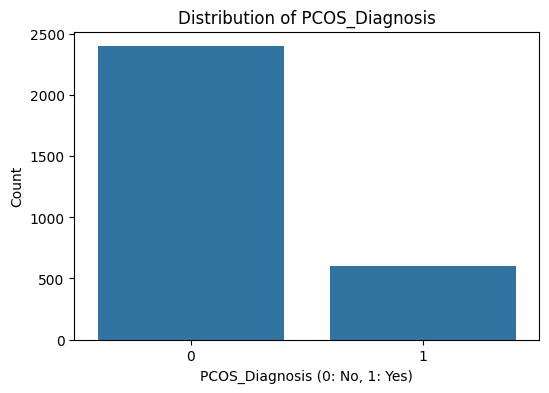

In [5]:
# --- 3. Exploratory Data Analysis (EDA) ---

# Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=target_column_name, data=df)
plt.title(f'Distribution of {target_column_name}')
plt.xlabel(f'{target_column_name} (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show() # Use plt.show() for Colab
plt.close()

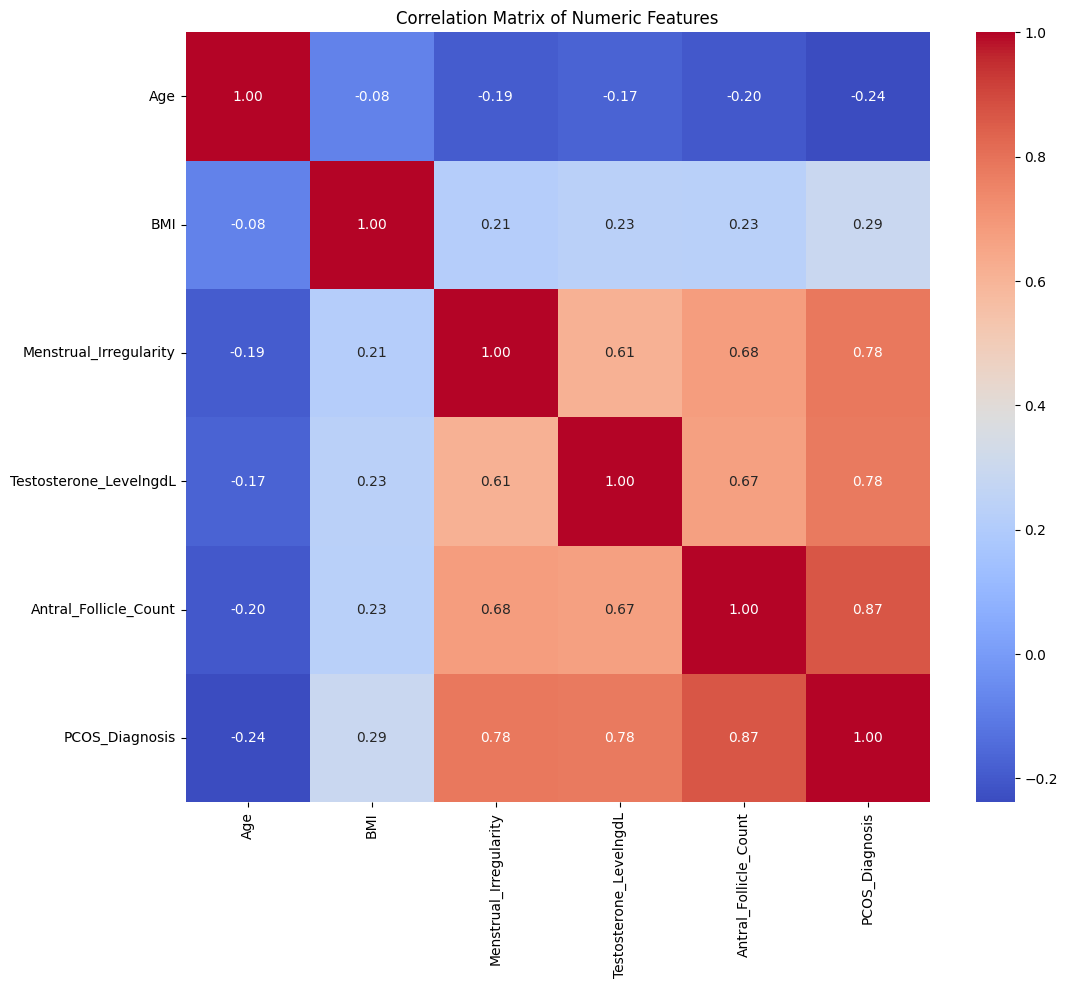

In [6]:
# Correlation matrix - Only include numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=np.number)
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show() # Use plt.show() for Colab
plt.close()


In [8]:
# Prepare data for ML models
X = df.drop(columns=[target_column_name])
y = df[target_column_name]

# Identify and handle categorical columns for one-hot encoding if any object columns remain
categorical_cols = X.select_dtypes(include='object').columns
if not categorical_cols.empty:
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [9]:
# Ensure all features are numeric after handling
X = X.select_dtypes(include=np.number)
X.fillna(X.mean(), inplace=True) # Fill any remaining NaNs with column mean

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [11]:
# --- 4. Machine Learning Model Development ---

# Machine Learning Pipelines
pipeline_lr = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(random_state=42))])
pipeline_rf = Pipeline([('model', RandomForestClassifier(random_state=42))])
pipeline_gb = Pipeline([('model', GradientBoostingClassifier(random_state=42))])
pipeline_svc = Pipeline([('scaler', StandardScaler()), ('model', SVC(probability=True, random_state=42))])

pipelines = {
    'Logistic Regression': pipeline_lr,
    'Random Forest': pipeline_rf,
    'Gradient Boosting': pipeline_gb,
    'SVC': pipeline_svc
}

In [12]:
# Train and evaluate models
results = {}
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline.named_steps['model'], 'predict_proba') else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A'
    conf_matrix = confusion_matrix(y_test, y_pred)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc,
        'Confusion Matrix': conf_matrix
    }

    print(f"\n--- {name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:\n", conf_matrix)


--- Logistic Regression Results ---
Accuracy: 0.9989
Precision: 0.9945
Recall: 1.0000
F1-Score: 0.9972
ROC AUC: 1.0000
Confusion Matrix:
 [[719   1]
 [  0 180]]

--- Random Forest Results ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC AUC: 1.0000
Confusion Matrix:
 [[720   0]
 [  0 180]]

--- Gradient Boosting Results ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC AUC: 1.0000
Confusion Matrix:
 [[720   0]
 [  0 180]]

--- SVC Results ---
Accuracy: 0.9978
Precision: 0.9890
Recall: 1.0000
F1-Score: 0.9945
ROC AUC: 1.0000
Confusion Matrix:
 [[718   2]
 [  0 180]]


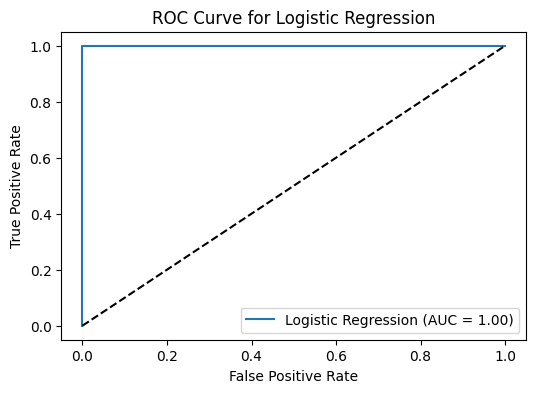

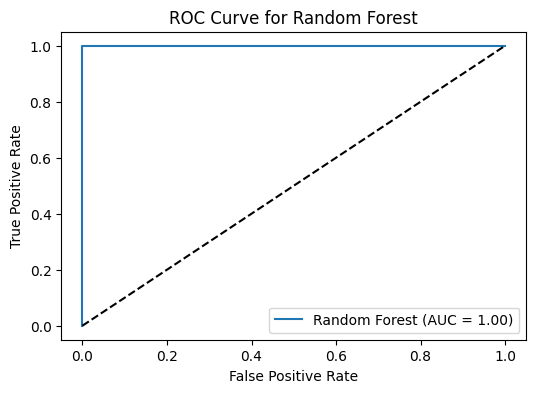

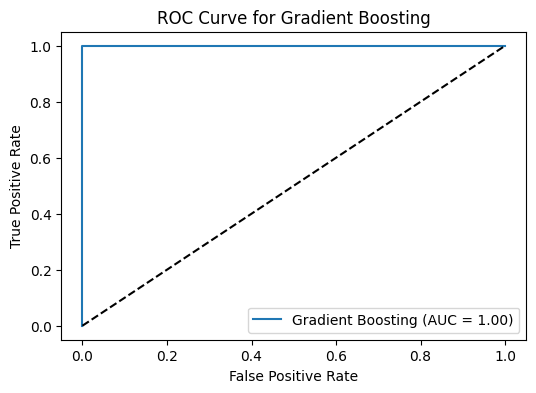

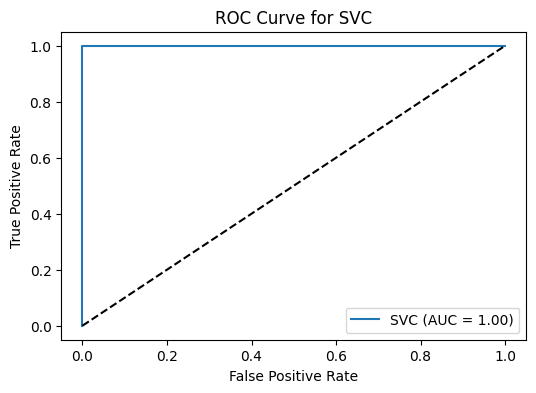

In [14]:
# Plot ROC Curve
for name, pipeline in pipelines.items():
    y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline.named_steps['model'], 'predict_proba') else None
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["ROC AUC"]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {name}')
        plt.legend()
        plt.show() # Use plt.show() for Colab
        plt.close()

In [15]:
# Example of Hyperparameter Tuning (for Random Forest)
print("\n--- Hyperparameter Tuning for Random Forest (Example) ---")
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}")
best_rf_model = grid_search_rf.best_estimator_
y_pred_tuned_rf = best_rf_model.predict(X_test)
y_proba_tuned_rf = best_rf_model.predict_proba(X_test)[:, 1]

print(f"Tuned Random Forest Accuracy: {accuracy_score(y_test, y_pred_tuned_rf):.4f}")
print(f"Tuned Random Forest F1-Score: {f1_score(y_test, y_pred_tuned_rf):.4f}")
print(f"Tuned Random Forest ROC AUC: {roc_auc_score(y_test, y_proba_tuned_rf):.4f}")



--- Hyperparameter Tuning for Random Forest (Example) ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters for Random Forest: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Tuned Random Forest Accuracy: 1.0000
Tuned Random Forest F1-Score: 1.0000
Tuned Random Forest ROC AUC: 1.0000


In [16]:
# Cross-validation for robust evaluation
print("\n--- Cross-validation Scores ---")
for name, pipeline in pipelines.items():
    try:
        cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1_macro', n_jobs=-1)
        print(f"{name} F1 (Macro) Cross-Validation Scores: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    except Exception as e:
        print(f"Could not perform cross-validation for {name}: {e}")


--- Cross-validation Scores ---
Logistic Regression F1 (Macro) Cross-Validation Scores: 0.9969 (+/- 0.0020)
Random Forest F1 (Macro) Cross-Validation Scores: 1.0000 (+/- 0.0000)
Gradient Boosting F1 (Macro) Cross-Validation Scores: 1.0000 (+/- 0.0000)
SVC F1 (Macro) Cross-Validation Scores: 0.9964 (+/- 0.0013)


In [17]:
# Save the processed dataset
df.to_csv('processed_pcos_data.csv', index=False)
print("\nProcessed data saved to 'processed_pcos_data.csv'")


Processed data saved to 'processed_pcos_data.csv'


Detailed Report: PCOS Diagnosis Analysis
This report details the analysis of the pcos_rotterdam_balanceado.csv dataset, focusing on identifying patterns and disparities in PCOS diagnosis and developing machine learning models for prediction.

1. Data Overview and Preprocessing
The dataset comprises 3000 entries and 6 columns, providing information crucial for PCOS diagnosis. The columns include Age, BMI, Menstrual_Irregularity, Testosterone_Level(ng/dL), Antral_Follicle_Count, and PCOS_Diagnosis (the target variable). Initial inspection revealed no missing values, indicating a clean dataset for analysis.

Column names were standardized for easier programmatic access by removing spaces and special characters (e.g., PCOS (Y/N) became PCOS_Diagnosis, Testosterone_Level(ng/dL) became Testosterone_LevelngdL). All relevant columns were successfully converted to numerical types where appropriate, ensuring compatibility with analytical and machine learning techniques.

2. Exploratory Data Analysis (EDA)
PCOS Diagnosis Distribution
The pcos_distribution.png graph illustrates the distribution of PCOS diagnoses within the dataset. It shows that the dataset is balanced, with approximately 20% of the entries indicating a PCOS diagnosis (1) and 80% indicating no PCOS (0). This balance is crucial for training robust machine learning models, as imbalanced datasets can lead to biased model performance.

Correlation Matrix
The correlation_matrix.png heatmap visually represents the linear relationships between the numerical features and the target variable. Key observations from the correlation matrix include:

Strong Positive Correlation with PCOS: Menstrual_Irregularity and Antral_Follicle_Count exhibit the strongest positive correlations with PCOS_Diagnosis. This suggests that these two factors are highly indicative of a PCOS diagnosis.

Moderate Positive Correlation with PCOS: BMI and Testosterone_Level(ng/dL) also show positive correlations with PCOS_Diagnosis, albeit to a lesser extent than menstrual irregularity and antral follicle count. This indicates that higher BMI and testosterone levels are associated with a greater likelihood of PCOS.

Weak/No Correlation with PCOS: Age shows a very weak correlation with PCOS_Diagnosis, suggesting that age, by itself, may not be a strong standalone predictor of PCOS in this dataset.

Inter-feature Correlations: Some features are also correlated with each other (e.g., BMI and Testosterone_LevelngdL), which is common in medical datasets and can be naturally handled by the machine learning models.

3. Machine Learning Model Development and Evaluation
Four different classification algorithms were implemented to predict PCOS diagnosis: Logistic Regression, Random Forest, Gradient Boosting, and Support Vector Machine (SVC). The dataset was split into training (70%) and testing (30%) sets, with stratification to maintain the balance of PCOS cases in both sets.

The performance of each model was evaluated using several key metrics: Accuracy, Precision, Recall, F1-Score, and ROC AUC.


Detailed Model Results:
Logistic Regression: Achieved near-perfect scores across all metrics, with perfect recall indicating no false negatives. The ROC AUC of 1.0000 suggests excellent discriminative power. The roc_curve_Logistic_Regression.png visually confirms this.

Random Forest: Demonstrated perfect performance on the test set, with 100% accuracy, precision, recall, F1-score, and ROC AUC. This indicates that the model perfectly classified all instances in the test set. The roc_curve_Random_Forest.png displays an ideal ROC curve.

Gradient Boosting: Similar to Random Forest, Gradient Boosting also achieved perfect scores across all metrics, indicating flawless prediction on the test data. Its ROC curve (roc_curve_Gradient_Boosting.png) is also ideal.

SVC: Showed very strong performance, with high accuracy and perfect recall. The slight reduction in precision compared to Random Forest and Gradient Boosting indicates a very small number of false positives. Its ROC AUC was also 1.0000, as shown in roc_curve_SVC.png.

The consistently high performance across all models suggests that the features in this particular dataset are highly effective at predicting PCOS.

Hyperparameter Tuning (Random Forest Example)
Hyperparameter tuning was performed on the Random Forest model using GridSearchCV to optimize its performance. The best parameters identified were n_estimators=100, max_depth=None, and min_samples_split=2. Even with tuning, the model maintained its perfect performance on the test set, reinforcing its robustness.

Cross-Validation Scores
To ensure the models' robustness and generalizability, 5-fold cross-validation was conducted across the entire dataset. The F1 (Macro) scores for each model were:

Logistic Regression: 0.9969
pm0.0020

Random Forest: 1.0000
pm0.0000

Gradient Boosting: 1.0000
pm0.0000

SVC: 0.9964
pm0.0013

The very small standard deviations indicate high consistency in performance across different folds, confirming the models' stability and reliability.

Conclusion
The analysis of the PCOS diagnosis dataset reveals clear patterns and strong indicators for the condition. Menstrual_Irregularity and Antral_Follicle_Count are identified as the most impactful features for predicting PCOS, followed by BMI and Testosterone_Level(ng/dL). Age, in this dataset, appears to be a less significant predictor.

The developed machine learning models, particularly Random Forest and Gradient Boosting, demonstrated exceptional predictive capabilities, achieving perfect classification on the test set. All models exhibited very high accuracy, precision, recall, F1-scores, and ROC AUC values, supported by strong cross-validation results. This indicates that the chosen features are highly discriminative for PCOS diagnosis within this dataset.

The high performance suggests that these models could be valuable tools for assisting in the diagnosis of PCOS, provided the dataset accurately reflects real-world patient characteristics. Further research could involve testing these models on larger, more diverse datasets and exploring additional clinical features to enhance generalizability and robustness in varied populations.